In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 50, 18
rcParams["axes.labelsize"] = 16
import seaborn as sns

import spacy
import re
from gensim import corpora, models, similarities

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("hotel_reviews.csv")
data.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [3]:
review_data = data[['Hotel_Name', 'Positive_Review', 'Negative_Review', 'Average_Score', 'Reviewer_Score']].copy()
review_data.head()

,Hotel_Name,Positive_Review,Negative_Review,Average_Score,Reviewer_Score
0,Hotel Arena,Only the park outside of the hotel was beauti...,I am so angry that i made this post available...,7.7,2.9
1,Hotel Arena,No real complaints the hotel was great great ...,No Negative,7.7,7.5
2,Hotel Arena,Location was good and staff were ok It is cut...,Rooms are nice but for elderly a bit difficul...,7.7,7.1
3,Hotel Arena,Great location in nice surroundings the bar a...,My room was dirty and I was afraid to walk ba...,7.7,3.8
4,Hotel Arena,Amazing location and building Romantic setting,You When I booked with your company on line y...,7.7,6.7


In [4]:

review_data['reviews'] = review_data[['Positive_Review', 'Negative_Review']].apply(lambda x: ' '.join(x), axis = 1)

print(review_data.loc[1, 'reviews'])

 No real complaints the hotel was great great location surroundings rooms amenities and service Two recommendations however firstly the staff upon check in are very confusing regarding deposit payments and the staff offer you upon checkout to refund your original payment and you can make a new one Bit confusing Secondly the on site restaurant is a bit lacking very well thought out and excellent quality food for anyone of a vegetarian or vegan background but even a wrap or toasted sandwich option would be great Aside from those minor minor things fantastic spot and will be back when i return to Amsterdam  No Negative


Review score given by Customer: 10.0    115853
9.6      71167
9.2      58583
8.8      46429
8.3      41128
7.5      34878
7.9      33097
7.1      24855
6.7      18793
6.3      14924
5.8      12034
5.4       9526
5.0       8422
4.6       6240
4.2       5095
3.8       4044
3.3       2772
2.5       2199
2.9       1589
9.5        724
9.0        647
8.5        508
8.0        505
7.0        411
6.5        345
6.0        253
5.5        227
4.5        122
4.0         84
3.5         79
9.4         63
8.1         39
3.0         37
6.9         29
5.6         17
4.4         12
3.1          8
Name: Reviewer_Score, dtype: int64


<AxesSubplot:title={'center':'Count of Reviews'}>

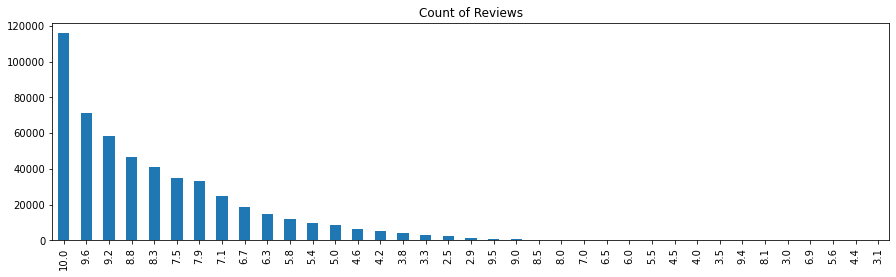

In [5]:

print(f"Review score given by Customer: {review_data.Reviewer_Score.value_counts()}")
review_data.Reviewer_Score.value_counts().plot(kind='bar', title='Count of Reviews', figsize = (15, 4))

<AxesSubplot:title={'center':'distribution of reviews'}>

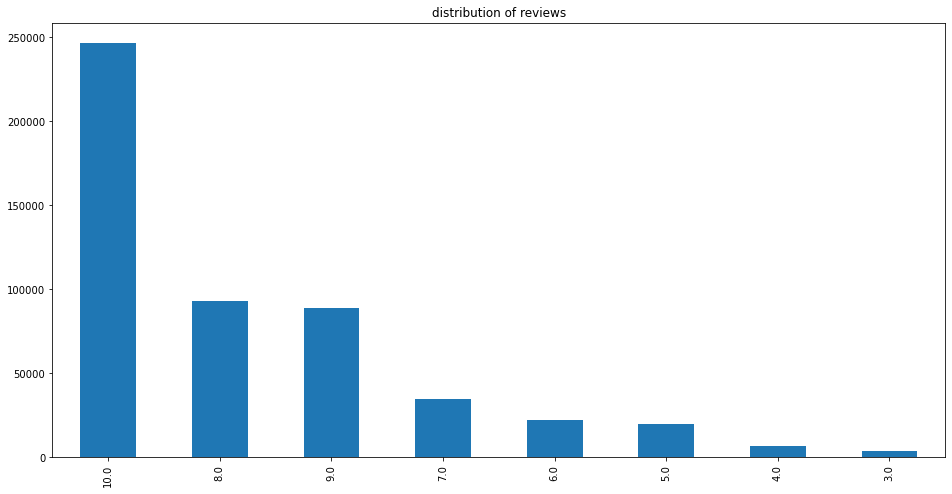

In [6]:

review_data['round_review_score'] = review_data.Reviewer_Score.apply(lambda x: np.ceil(x))
review_data.round_review_score.value_counts().plot(kind = 'bar', figsize=(16, 8), title = 'distribution of reviews')

In [7]:

print(f"Before subseting, data size: {data.shape}")
reviews_df = review_data.sample(frac = 0.1, replace = False, random_state=42)
print(f"After subseting, data size: {reviews_df.shape}")
reviews_df.head()

Before subseting, data size: (515738, 17)
After subseting, data size: (51574, 7)


,Hotel_Name,Positive_Review,Negative_Review,Average_Score,Reviewer_Score,reviews,round_review_score
488440,Hotel Da Vinci,Hotel was great clean friendly staff free bre...,Would have appreciated a shop in the hotel th...,8.1,9.6,Hotel was great clean friendly staff free bre...,10.0
274649,Urban Lodge Hotel,No Positive,No tissue paper box was present at the room,8.6,8.8,No Positive No tissue paper box was present a...,9.0
374688,Alexandra Barcelona A DoubleTree by Hilton,Nice welcoming and service,Pillows,8.3,7.9,Nice welcoming and service Pillows,8.0
404352,Hotel Principe Di Savoia,Everything including the nice upgrade The Hot...,No Negative,9.1,10.0,Everything including the nice upgrade The Hot...,10.0
451596,Hotel Esther a,Lovely hotel v welcoming staff,No Negative,9.1,9.6,Lovely hotel v welcoming staff No Negative,10.0


In [8]:

from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import strip_tags, strip_punctuation, strip_numeric
from gensim.parsing.preprocessing import strip_multiple_whitespaces, strip_non_alphanum, remove_stopwords, strip_short

CUSTOM_FILTERS = [lambda x: str(x), 
                  lambda x: x.lower(), 
                  
                  lambda x: re.sub('[^\s]*.com[^\s]*', "", x),
                  lambda x: re.sub('[^\s]*www.[^\s]*', "", x),
                  lambda x: re.sub('[^\s]*.co.uk[^\s]*', "", x),
                  
                  lambda x: re.sub('[^\s]*[\*]+[^\s]*', "", x),
                  lambda x: re.sub(r'\([^)]*\)', '', x),
                  strip_tags, 
                  strip_punctuation, 
                  strip_non_alphanum, 
                  strip_numeric, 
                  remove_stopwords,
                  strip_short, 
                  strip_multiple_whitespaces
                 ]
import spacy
nlp = spacy.load("en_core_web_md")

def text_preprocess(docs, logging=True):
    docs = [preprocess_string(text, CUSTOM_FILTERS) for text in docs]
    texts_out = []
    for doc in docs:
    
        doc = nlp((" ".join(doc)),  
                  
                  disable=['ner', 
                           'tagger', 
                           'textcat', #
                          ])
        texts_out.append([tok.lemma_ for tok in doc if tok.lemma_ != '-PRON-'])
    return pd.Series(texts_out)


In [9]:

%time train_corpus = text_preprocess(reviews_df.reviews)

Wall time: 2min 18s


In [10]:

ngram_phraser_1 = models.Phrases(train_corpus, threshold=1)
ngram_phraser_2 = models.Phrases(train_corpus, threshold=10)
ngram_1 = models.phrases.Phraser(ngram_phraser_1)
ngram_2 = models.phrases.Phraser(ngram_phraser_2)

print(ngram_1[train_corpus[0]])
print(ngram_2[train_corpus[0]])

['hotel', 'great', 'clean', 'friendly_staff', 'free', 'breakfast_morning', 'good_selection', 'good_wifi', 'connection', 'nice_size', 'room', 'bath', 'fridge_room', 'personally', 'love_fact', 'hotel', 'isn', 'city_centre', 'literally', 'train_station', 'easily', 'airport_city', 'definitely_stay', 'appreciate', 'shop', 'hotel', 'sell', 'drink_water', 'necessity', 'like', 'arrive_late', 'night', 'bring', 'drink', 'plane', 'airport', 'shop_nearby', 'minibar', 'want_pay', 'price']
['hotel', 'great', 'clean', 'friendly', 'staff', 'free', 'breakfast', 'morning', 'good', 'selection', 'good', 'wifi_connection', 'nice', 'size', 'room', 'bath', 'fridge', 'room', 'personally', 'love', 'fact', 'hotel', 'isn', 'city_centre', 'literally', 'train_station', 'easily', 'airport', 'city', 'definitely_stay', 'appreciate', 'shop', 'hotel', 'sell', 'drink', 'water', 'necessity', 'like', 'arrive_late', 'night', 'bring', 'drink', 'plane', 'airport', 'shop_nearby', 'minibar', 'want', 'pay', 'price']


In [11]:

texts_1 = [ngram_1[token] for token in train_corpus]
texts_2 = [ngram_2[token] for token in train_corpus]

texts_1 = [' '.join(text) for text in texts_1]
texts_2 = [' '.join(text) for text in texts_2]
reviews_df['ngram_1'] = texts_1
reviews_df['ngram_2'] = texts_2

reviews_df.head()

,Hotel_Name,Positive_Review,Negative_Review,Average_Score,Reviewer_Score,reviews,round_review_score,ngram_1,ngram_2
488440,Hotel Da Vinci,Hotel was great clean friendly staff free bre...,Would have appreciated a shop in the hotel th...,8.1,9.6,Hotel was great clean friendly staff free bre...,10.0,hotel great clean friendly_staff free breakfas...,hotel great clean friendly staff free breakfas...
274649,Urban Lodge Hotel,No Positive,No tissue paper box was present at the room,8.6,8.8,No Positive No tissue paper box was present a...,9.0,positive tissue paper box present room,positive tissue paper box present room
374688,Alexandra Barcelona A DoubleTree by Hilton,Nice welcoming and service,Pillows,8.3,7.9,Nice welcoming and service Pillows,8.0,nice service pillow,nice service pillow
404352,Hotel Principe Di Savoia,Everything including the nice upgrade The Hot...,No Negative,9.1,10.0,Everything including the nice upgrade The Hot...,10.0,include nice upgrade hotel revamp surprise lov...,include nice upgrade hotel revamp surprise lov...
451596,Hotel Esther a,Lovely hotel v welcoming staff,No Negative,9.1,9.6,Lovely hotel v welcoming staff No Negative,10.0,lovely_hotel staff negative,lovely hotel staff negative


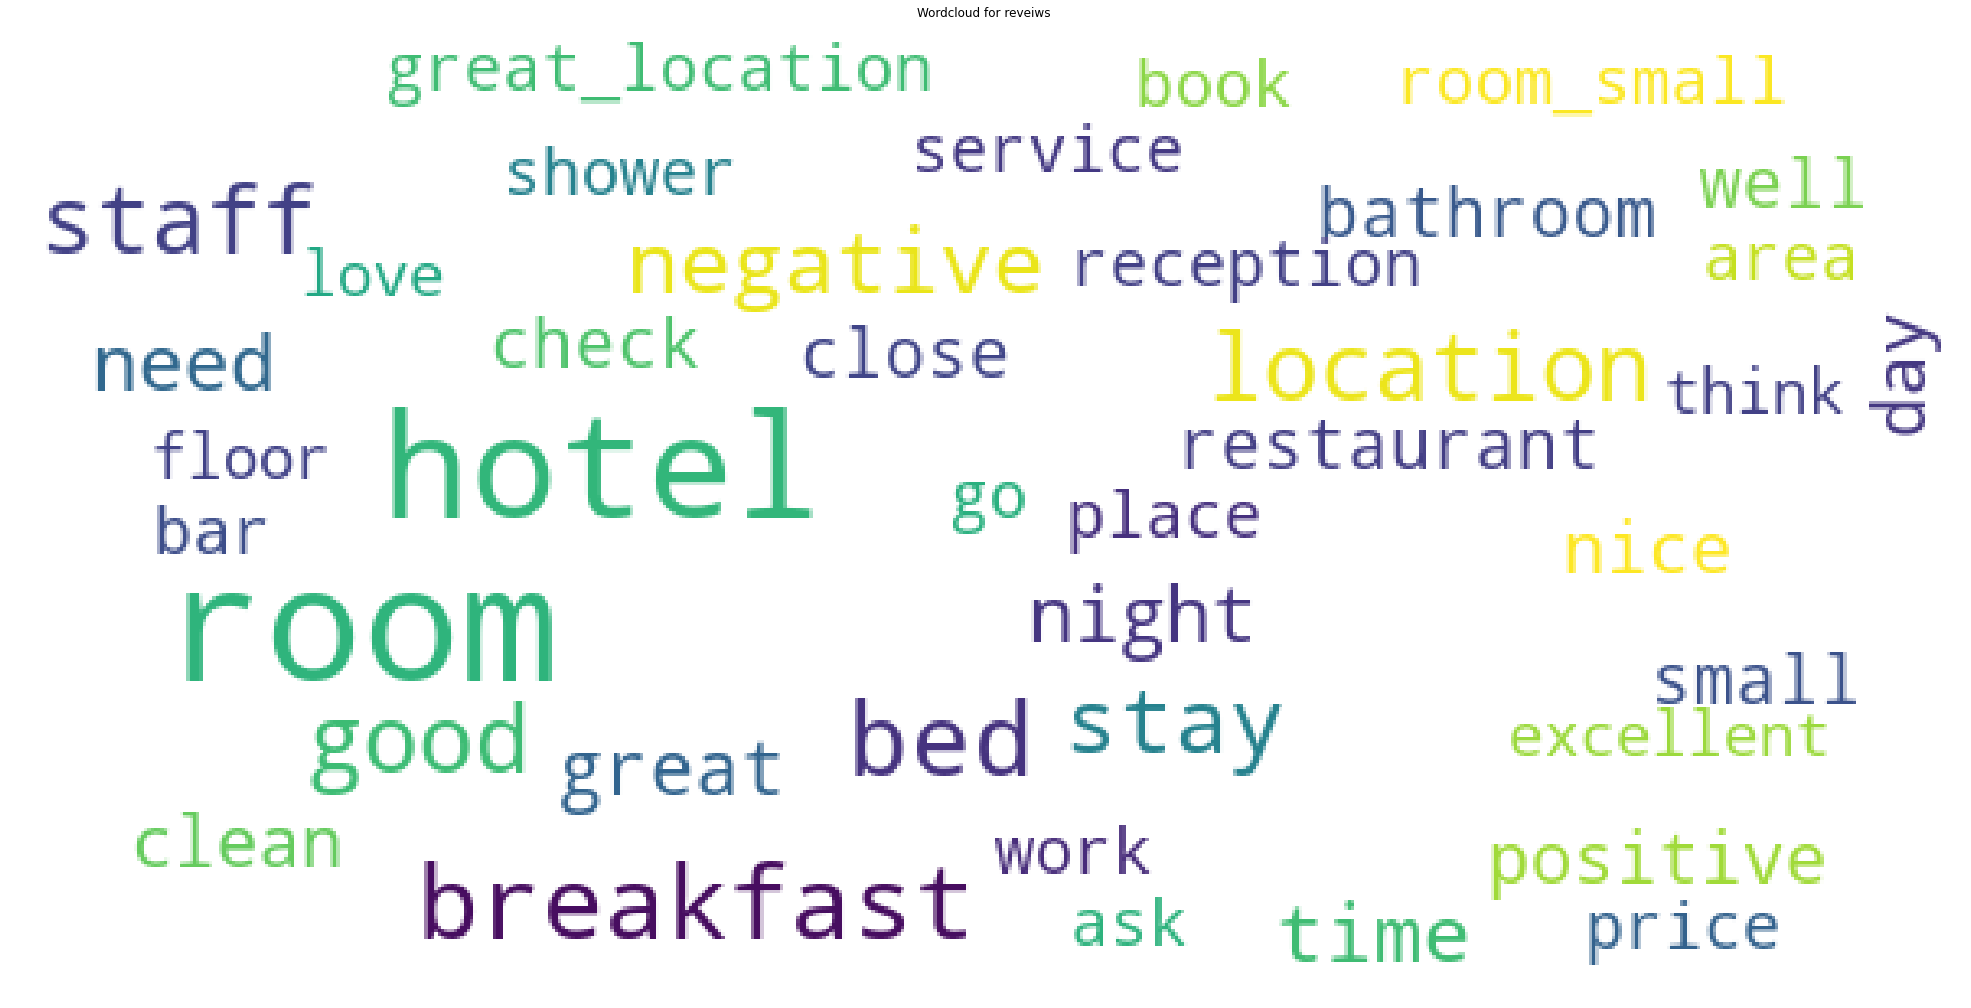

In [12]:

from wordcloud import WordCloud

text = ""
for i in range(reviews_df.shape[0]):
    text = " ".join([text,reviews_df["ngram_1"].values[i]])
    

wordcloud = WordCloud(background_color='white', width=600, height=300, max_font_size=50, max_words=40).generate(text)
wordcloud.recolor(random_state=312)
plt.imshow(wordcloud)
plt.title("Wordcloud for reveiws ")
plt.axis("off")

plt.show()

<AxesSubplot:title={'center':'After sampling Review distribution'}>

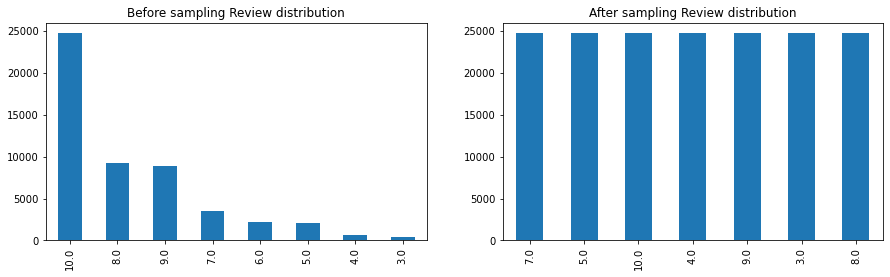

In [16]:

fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
reviews_df.round_review_score.value_counts().plot(kind='bar', title='Before sampling Review distribution', ax = ax1)


counts_category = reviews_df.round_review_score.value_counts().values


df_class_10 = reviews_df[reviews_df.round_review_score == 10.0]
df_class_8 = reviews_df[reviews_df.round_review_score == 8.0]
df_class_9 = reviews_df[reviews_df.round_review_score == 9.0]
df_class_7 = reviews_df[reviews_df.round_review_score == 7.0]
df_class_5 = reviews_df[reviews_df.round_review_score == 5.0]
df_class_4 = reviews_df[reviews_df.round_review_score == 4.0]
df_class_3 = reviews_df[reviews_df.round_review_score == 3.0]


df_class_10 = df_class_10.sample(counts_category[0], replace=False)
df_class_9 = df_class_9.sample(counts_category[0], replace=True)
df_class_8 = df_class_8.sample(counts_category[0], replace=True)
df_class_7 = df_class_7.sample(counts_category[0], replace=True)
df_class_5 = df_class_5.sample(counts_category[0], replace=True)
df_class_4 = df_class_4.sample(counts_category[0], replace=True)
df_class_3 = df_class_3.sample(counts_category[0], replace=True)


df_train_oversampled = pd.concat([df_class_10, df_class_9, df_class_8, df_class_7, df_class_5, df_class_4, df_class_3], axis=0)



df_train_oversampled.round_review_score.value_counts().plot(kind='bar', title='After sampling Review distribution', ax = ax2)


In [19]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
import xgboost as xgb
from sklearn.ensemble import VotingClassifier


vectorizer_1 = CountVectorizer()
vectorizer_1.fit(df_train_oversampled.ngram_1)


X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(df_train_oversampled.ngram_1, df_train_oversampled.round_review_score, test_size=0.4)


vectorizer_2 = CountVectorizer()
vectorizer_2.fit(df_train_oversampled.ngram_2)


X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_train_oversampled.ngram_2, df_train_oversampled.round_review_score, test_size=0.4)

In [20]:


lr_1 = LogisticRegression()
lr_1.fit(vectorizer_1.transform(X_train_1), y_train_1)

lr_2 = LogisticRegression()
lr_2.fit(vectorizer_2.transform(X_train_2), y_train_2)

print('Logistic Regression Score on ngram_1 reviews: ', lr_1.score(vectorizer_1.transform(X_test_1), y_test_1))
print('Logistic Regression Score on ngram_2 reviews: ', lr_2.score(vectorizer_2.transform(X_test_2), y_test_2))

y_1 = lr_1.predict(vectorizer_1.transform(X_test_1))
print("classification report on ngram_1 reviews:\n ", classification_report(y_test_1, y_1))

y_2 = lr_2.predict(vectorizer_2.transform(X_test_2))
print("classification report on ngram_2 reviews:\n ", classification_report(y_test_2, y_2))

Logistic Regression Score on ngram_1 reviews:  0.7609387200323896
Logistic Regression Score on ngram_2 reviews:  0.6904045808149455
classification report on ngram_1 reviews:
                precision    recall  f1-score   support

         3.0       0.91      0.96      0.94     10045
         4.0       0.92      0.93      0.93      9875
         5.0       0.87      0.91      0.89      9892
         7.0       0.79      0.79      0.79      9796
         8.0       0.59      0.56      0.57      9795
         9.0       0.58      0.58      0.58      9888
        10.0       0.63      0.59      0.61      9867

    accuracy                           0.76     69158
   macro avg       0.76      0.76      0.76     69158
weighted avg       0.76      0.76      0.76     69158

classification report on ngram_2 reviews:
                precision    recall  f1-score   support

         3.0       0.87      0.96      0.91      9839
         4.0       0.87      0.88      0.88      9951
         5.0       0

In [21]:

test_data = reviews_df.sample(frac = 0.05, replace = False, random_state=42)
test_data = test_data[['reviews', 'ngram_1', 'ngram_2']].copy()

prediction_1 = lr_1.predict(vectorizer_1.transform(test_data.ngram_1))


prediction_2 = lr_2.predict(vectorizer_2.transform(test_data.ngram_2))

sample_test_score = pd.DataFrame({'Review_ngram_1':test_data.ngram_1, 'Review_ngram_2': test_data.ngram_2, 'score_ngram_1':prediction_1, 'score_ngram_2':prediction_2})
sample_test_score.to_csv('sample_test_score.csv', index=False)
sample_test_score.head()

,Review_ngram_1,Review_ngram_2,score_ngram_1,score_ngram_2
385524,clean extremely_small room price,clean extremely small room price,5.0,4.0
403309,staff_reception helpful,staff reception helpful,9.0,9.0
42185,lovely staff ball know precisely pool fantasti...,lovely staff ball know precisely pool fantasti...,10.0,10.0
286648,location warm_atmosphere good bed furniture ro...,location warm atmosphere good bed furniture ro...,8.0,8.0
109058,exceptional highly_negative,exceptional highly negative,10.0,10.0


In [22]:

from scipy import stats

filter_data = sample_test_score.dropna(subset=['score_ngram_1', 'score_ngram_2'])
ttest, pval = stats.ttest_ind(filter_data.score_ngram_1, filter_data.score_ngram_2)
if pval<0.5:
  print("scores is almost same:", ttest, pval)
else:
  print("scores is different: ", ttest, pav)

scores is almost same: 1.888241233915537 0.05904966444260743


<AxesSubplot:title={'center':'ngram_2 pridiction'}>

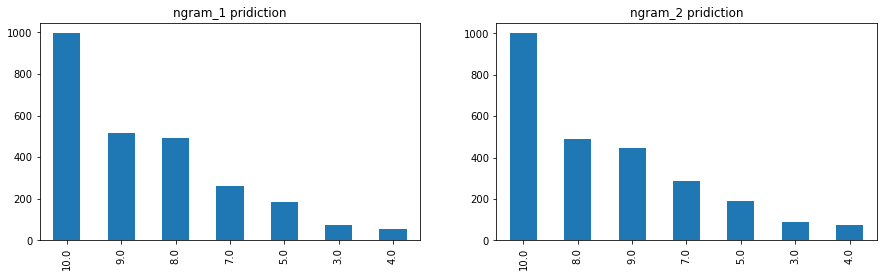

In [23]:
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sample_test_score.score_ngram_1.value_counts().plot(kind='bar', title='ngram_1 pridiction', ax = ax1)
sample_test_score.score_ngram_2.value_counts().plot(kind='bar', title='ngram_2 pridiction', ax = ax2)